In [1]:
from math import tan, atan, sin, cos, pi, radians
import json
import os
from PIL import Image
import numpy as np

In [2]:
img_path = './data/rgb_carla.png'
depth_path = './data/depth_carla.png'

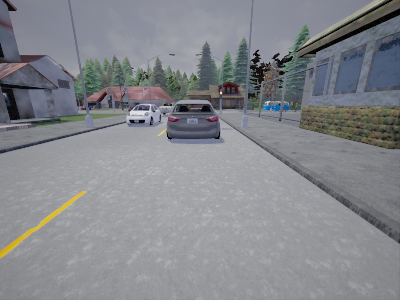

In [3]:
Image.open(img_path).convert('RGB').resize((400, 300))

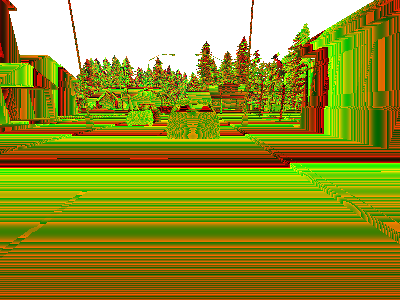

In [4]:
Image.open(depth_path).convert('RGB').resize((400, 300))

In [5]:
depth = np.array(Image.open(depth_path))
img = np.array(Image.open(img_path).convert('RGB'))

In [7]:
#Convert CARLA depth map (follow method specified in the CARLA documentation https://carla.readthedocs.io/en/stable/cameras_and_sensors/)
far = 1000
depth_metric = (depth[:,:,0] + depth[:,:,1]*256 + depth[:,:,2]*(256*256)) / (256*256*256 - 1)
depth_metric = depth_metric * far

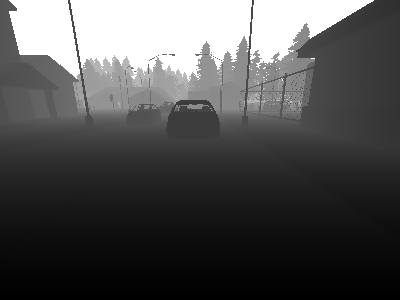

In [8]:
#plot log depth for better visualization
logdepth = np.log(depth_metric)
Image.fromarray((logdepth - np.min(logdepth))/(np.max(logdepth) - np.min(logdepth))*255).convert('L').resize((400, 300))

In [29]:
H, W = depth_metric.shape
coord1, coord2 =  np.mgrid[range(H), range(W)]
coords_plane = np.c_[coord2.ravel(), coord1.ravel()]
coords3 = np.append(coords_plane, -np.expand_dims(depth_metric.flatten(), axis = 1), axis = 1)
coords3[:, 0] = np.multiply(coords3[:, 0],coords3[:, 2])
coords3[:, 1] = np.multiply(coords3[:, 1],coords3[:, 2])


FOVx =radians(100)   
FOVy = 2*atan(H/W * tan(radians(100)/2))

cy = (H/2)
cx = W/2
fx = cx / tan(FOVx/2)
fy = cy/ tan(FOVy/2)

Kc = np.array([
                    [fx, 0, cx ],
                    [0, fy, cy],
                    [0, 0, 1]])

inv_Kc = np.linalg.inv(Kc)

#get the coordinates in the camera coordinate system
coords_proj = np.transpose(inv_Kc @ np.transpose(coords3))
epsilon = radians(-15)
rotation = np.array(
    [[1, 0, 0], [0, cos(epsilon), -sin(epsilon)], [0, sin(epsilon), cos(epsilon)]]
)
# we actually right apply the transpose of the rotation matrix  which is the same as left applying the matrix from camera coordinate system to real
coords_proj_ =coords_proj@np.transpose(rotation)


In [34]:
#pinhole inverses
coords_proj_[:,0] = -coords_proj_[:,0]

In [35]:
#add translation (camera level is 0 but in real it's 1.4 m above ground)
coords_proj_[:,1] += 1.4

In [36]:
coords_proj_

array([[-1.40996914e+01,  8.55234206e+00, -1.41648642e+01],
       [-1.40997287e+01,  8.57028669e+00, -1.42004027e+01],
       [-1.40998012e+01,  8.58833943e+00, -1.42361553e+01],
       ...,
       [ 1.49448652e+00, -1.42352626e-02, -9.29127569e-01],
       [ 1.49825097e+00, -1.42352626e-02, -9.29127569e-01],
       [ 1.50201542e+00, -1.42352626e-02, -9.29127569e-01]])

# Make Point cloud visualization

In [37]:
import open3d

In [38]:
nonsky = np.where(depth_metric.flatten() != 1000 ) 

In [39]:
#get better viz if far pixels are not included
pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(coords_proj_.reshape(600*800,3)[nonsky[0], : ])
pcd.colors = open3d.utility.Vector3dVector(img.reshape(600*800, 3)[nonsky[0], : ]/255)
open3d.visualization.draw_geometries([pcd])

# Flood

In [41]:
threshold = 1

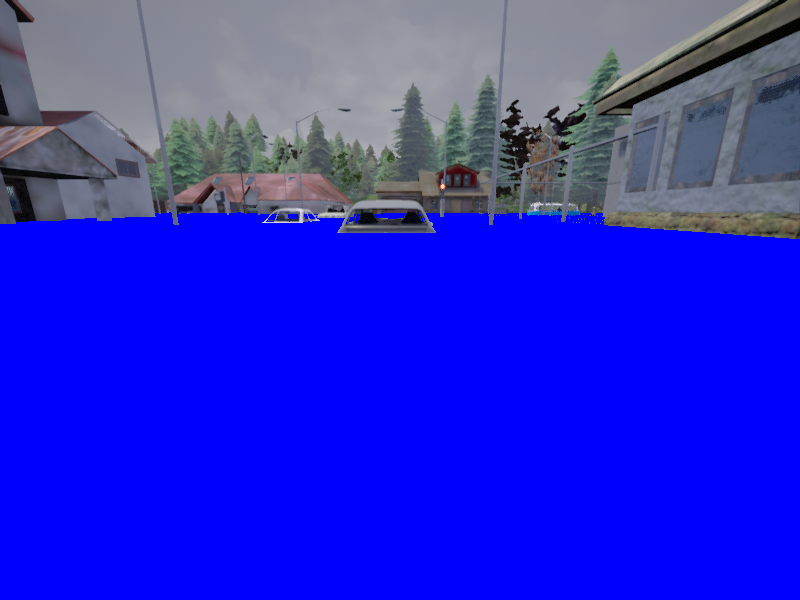

In [42]:
flood = np.where(coords_proj_[:,1]<threshold)
colors = np.array(img.copy().reshape(600*800, 3))
colors[flood, :] = [0,0,255]
flooded_im = colors.reshape(600,800, 3)
Image.fromarray(flooded_im)